<center><img src='https://monkeylearn.com/static/img/text-classification-with-naive-bayes.png'width="800"/></center>

<center><h3>Predicting tweet sentiments</h3></center>

## Problem Statement

You work in an event management company. On Mother's Day, your company has organized an event where they want to cast positive Mother's Day related tweets in a presentation. Data engineers have already collected the data related to Mother's Day that must be categorized into positive, negative, and neutral tweets.

You are appointed as a Machine Learning Engineer for this project. Your task is to build a model that helps the company classify these sentiments of the tweets into positive, negative, and neutral.

### Data description

This data set consists of six columns:

Column Name	Description
id	ID of tweet
original_text	Text of tweet
lang	Language of tweet
retweet_count	Number of times retweeted
original_author	Twitter handle of Author
sentiment_class	Sentiment of Tweet (Target)

In [1]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, string #textblob,
from sklearn.metrics import f1_score
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# vaderSentiment
# good - 0.34
# bad - -.45
# better - 0.56

## Exploration
Let’s get a feel for our data. Here are the first 5 rows of the training data:

In [3]:
test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [4]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [5]:
train.sentiment_class.value_counts()

 0    1701
-1     769
 1     765
Name: sentiment_class, dtype: int64

In [6]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\va4nfjfq5b", " ")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [7]:
train['original_text']=train['original_text'].apply(tweet_cleaner)

In [8]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,happy mothersday to all you amazing mothers ou...,en,0,BeenXXPired,0
1,1.245759e+18,happy mothers day mum i m sorry i can t be the...,en,1,FestiveFeeling,0
2,1.246087e+18,happy mothers day to all this doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,happy mothers day to this beautiful woman roya...,en,0,Queenuchee,0
4,1.244876e+18,remembering the most amazing ladies who made m...,en,0,brittan17446794,-1


In [9]:
test['original_text']=test['original_text'].apply(tweet_cleaner)

In [10]:
test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,yeah i once cooked potatoes when i was years o...,en,0,LToddWood
1,1.245898e+18,happy mother s day to all the mums step mums g...,en,0,iiarushii
2,1.244717e+18,i love the people from the uk however when i a...,en,0,andreaanderegg
3,1.245730e+18,happy st birthday happy mother s day to my mum...,en,1,TheBookTweeters
4,1.244636e+18,happy mothers day to all those wonderful mothe...,en,0,andreaanderegg


## Data Preparation 1: HTML decoding

In [11]:
# import re
# def preprocess_text(text):
#     text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
#     text = re.sub('@[^\s]+','USER', text)
#     text = text.lower().replace("ё", "е")
#     text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
#     text = re.sub(' +',' ', text)
#     return text.strip()

In [12]:
# train['original_text']=train['original_text'].apply(preprocess_text)

In [13]:
# train['original_text'][0]

In [14]:
# test['original_text']=test['original_text'].apply(preprocess_text)

In [15]:
# test.head()

## Stemming and Lemmatization

We have an immense number of word forms as you can see from our various counts in the `FreqDist` above - it is helpful for many applications to normalize these word forms (especially applications like search) into some canonical word for further exploration. In English (and many other languages) - morphological context indicate gender, tense, quantity, etc. but these 

In [16]:
# import nltk
# from nltk.stem.wordnet import WordNetLemmatizer
# import string
# from nltk.corpus import wordnet as wn
# from nltk.tokenize.treebank import TreebankWordDetokenizer


# # ## Module constants
# # lemmatizer  = WordNetLemmatizer()
# # stopwords   = set(nltk.corpus.stopwords.words('english'))
# # punctuation = string.punctuation

# # def tagwn(tag):
# #     """
# #     Returns the WordNet tag from the Penn Treebank tag.
# #     """

# #     return {
# #         'N': wn.NOUN,
# #         'V': wn.VERB,
# #         'R': wn.ADV,
# #         'J': wn.ADJ
# #     }.get(tag[0], wn.NOUN)


# # def normalize(text):
# #     texts=list(nltk.word_tokenize(text))
# #     for token, tag in nltk.pos_tag(texts):
# #         #if you're going to do part of speech tagging, do it here
# #         token = token.lower()
# #         if token in stopwords and token in punctuation:
# #             continue
# #         token = lemmatizer.lemmatize(token, tagwn(tag))
# #         tokens=root_text=''.join(token)
# #         yield tokens

# # print(list(normalize("The eagle flies at midnight.")))

# # Note: use part of speech tag, we'll see this in machine learning! 
# def lemmatize(text):
#     text_final=list(nltk.word_tokenize(text))
#     lemmatizer = WordNetLemmatizer()
#     lemmas = [lemmatizer.lemmatize(t) for t in text_final]
#     root_text=' '.join(lemmas)
#     return root_text

In [17]:
#  create a dataframe using texts and lables

texts=train['original_text']
labels=train['sentiment_class']
#  split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels,test_size=0.33, random_state=42)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

### 2. Feature Engineering
The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

- 2.1 Count Vectors as features
- 2.2 TF-IDF Vectors as features

    - Word level
    - N-Gram level
    - Character level
    
- 2.3 Word Embeddings as features
- 2.4 Text / NLP based features
- 2.5 Topic Models as features

Lets look at the implementation of these ideas in detail

### 2.1 Count Vectors as features
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [18]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(texts)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

#### 2.2 TF-IDF Vectors as features
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
- IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

##### TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

- a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
- b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
- c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

In [19]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(texts)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(texts)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(texts)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)



C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [20]:
# from sklearn.naive_bayes import MultinomialNB

# nb = MultinomialNB()

# nb.fit(xtrain_count, train_y)

# s=metrics.accuracy_score(X_train_vect, y_train)

# y_pred = nb.predict(xvalid_count)



## ---------------------------------------------------------------------------------------------------------------------------------

In [21]:
def train_models_out(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
#     add_element(d,(metrics.accuracy_score(predictions, valid_y)),accuracy_score)
#     add_element(d,,f1_score)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    return predictions

## ---------------------------------fuction for f1_score--------------------------------------------------------------------

In [22]:
def train_models(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
#     add_element(d,(metrics.accuracy_score(predictions, valid_y)),accuracy_score)
#     add_element(d,,f1_score)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    return print(classification_report(valid_y, predictions, digits=4))#(f1_score(predictions, valid_y,average='weighted') * 100)

In [23]:
# Naive Bayes on Count Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ",accuracy)

              precision    recall  f1-score   support

           0     0.2857    0.0295    0.0535       271
           1     0.5040    0.9389    0.6559       540
           2     0.2353    0.0311    0.0550       257

    accuracy                         0.4897      1068
   macro avg     0.3417    0.3332    0.2548      1068
weighted avg     0.3839    0.4897    0.3584      1068

NB, Count Vectors:  None
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       271
           1     0.5056    0.9981    0.6712       540
           2     0.5000    0.0039    0.0077       257

    accuracy                         0.5056      1068
   macro avg     0.3352    0.3340    0.2263      1068
weighted avg     0.3760    0.5056    0.3412      1068

NB, WordLevel TF-IDF:  None
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       271
           1     0.5061    0.9907    0.6700       540
           2     0.142

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Linear Classifier on Count Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0     0.2638    0.1587    0.1982       271
           1     0.4973    0.6926    0.5789       540
           2     0.2288    0.1362    0.1707       257

    accuracy                         0.4232      1068
   macro avg     0.3300    0.3292    0.3159      1068
weighted avg     0.3735    0.4232    0.3841      1068

LR, Count Vectors:  None
              precision    recall  f1-score   support

           0     0.3043    0.0258    0.0476       271
           1     0.5015    0.9444    0.6551       540
           2     0.1786    0.0195    0.0351       257

    accuracy                         0.4888      1068
   macro avg     0.3281    0.3299    0.2459      1068
weighted avg     0.3738    0.4888    0.3518      1068

LR, WordLevel TF-IDF:  None
              precision    recall  f1-score   support

           0     0.0769    0.0074    0.0135       271
           1     0.4995    0.9463    0.6539       540
           2     0.263

In [25]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_models(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       271
           1     0.5052    0.9907    0.6692       540
           2     0.2857    0.0078    0.0152       257

    accuracy                         0.5028      1068
   macro avg     0.2636    0.3328    0.2281      1068
weighted avg     0.3242    0.5028    0.3420      1068

SVM, N-Gram Vectors:  None


In [70]:
test['sentiment_class']=accuracy

In [71]:
test.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.246628e+18,3 yeah i once cooked potato when i wa 3 year o...,en,0,LToddWood,1
1,1.245898e+18,happy mother s day to all the mum step mum gra...,en,0,iiarushii,1
2,1.244717e+18,i love the people from the uk however when i a...,en,0,andreaanderegg,1
3,1.245730e+18,happy 81st birthday happy mother s day to my m...,en,1,TheBookTweeters,1
4,1.244636e+18,happy mother day to all those wonderful mother...,en,0,andreaanderegg,1


In [72]:
final=pd.DataFrame(test[['id','sentiment_class']])
final.to_csv('submission_may.csv',index=False,sep=',')
# dt.to_csv('file_name.csv',sep='\t')

### Predict final Data

In [222]:
classifier_nv=naive_bayes.MultinomialNB(alpha=0.1)
classifier_nv.fit(xtrain_count, train_y)

MultinomialNB(alpha=0.1)

In [225]:
pred=classifier_nv.predict(xvalid_count)

In [226]:
f1_score(pred, valid_y,average='weighted') * 100

35.55359886554546

In [224]:
=classifier_nv.predict(tvalid_count)

array([1, 1, 2, ..., 2, 2, 0], dtype=int64)

## ------------------------------------------function for accuracy--------------------------------------------------------

In [72]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

### 3.1 Naive Bayes
Implementing a naive bayes model using sklearn implementation with different features

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

In [87]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ",accuracy)

NB, Count Vectors:  0.5018541409147095
NB, WordLevel TF-IDF:  0.5253399258343634
NB, N-Gram Vectors:  0.5241038318912238
NB, CharLevel Vectors:  0.5278121137206427


### 3.2 Linear Classifier
Implementing a Linear Classifier (Logistic Regression)

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. One can read more about logistic regression

In [88]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  0.449938195302843
LR, WordLevel TF-IDF:  0.49814585908529047
LR, N-Gram Vectors:  0.5055624227441285
LR, CharLevel Vectors:  0.5006180469715699


## 3.3 Implementing a SVM Model
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes. One can read more about i

In [89]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.5302843016069221


### 3.4 Bagging Model
Implementing a Random Forest Model

Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family. One can read more about Bagging and random forests

In [26]:
# RF on Count Vectors
accuracy = train_models(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_models(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       271
           1     0.5052    0.9889    0.6688       540
           2     0.4286    0.0117    0.0227       257

    accuracy                         0.5028      1068
   macro avg     0.3113    0.3335    0.2305      1068
weighted avg     0.3586    0.5028    0.3436      1068

RF, Count Vectors:  None
              precision    recall  f1-score   support

           0     0.1818    0.0074    0.0142       271
           1     0.5033    0.9778    0.6646       540
           2     0.2500    0.0078    0.0151       257

    accuracy                         0.4981      1068
   macro avg     0.3117    0.3310    0.2313      1068
weighted avg     0.3608    0.4981    0.3432      1068

RF, WordLevel TF-IDF:  None


### 3.5 Boosting Model
Implementing Xtereme Gradient Boosting Model

Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). Read more about these models

In [27]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

              precision    recall  f1-score   support

           0     0.3000    0.0221    0.0412       271
           1     0.5092    0.9778    0.6696       540
           2     0.2727    0.0117    0.0224       257

    accuracy                         0.5028      1068
   macro avg     0.3606    0.3372    0.2444      1068
weighted avg     0.3992    0.5028    0.3544      1068

Xgb, Count Vectors:  None
              precision    recall  f1-score   support

           0     0.1724    0.0185    0.0333       271
           1     0.5029    0.9574    0.6594       540
           2     0.2727    0.0117    0.0224       257

    accuracy                         0.4916      1068
   macro avg     0.3160    0.3292    0.2384      1068
weighted avg     0.3637    0.4916    0.3473      1068

Xgb, WordLevel TF-IDF:  None
              precision    recall  f1-score   support

           0     0.2500    0.0185    0.0344       271
           1     0.5034    0.9537    0.6590       540
           2     0.1

In [92]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  65.41156325968433
Xgb, WordLevel TF-IDF:  65.50825104837983
Xgb, CharLevel Vectors:  65.4423509809935


## ----------------------------------------------------

In [388]:
# Splitting the dataset into train and test set
X_train, X_test = train_test_split(train,test_size = 0.5)
# Removing neutral sentiments
# train = train[train.sentiment_class !=0]

In [389]:
X_train.shape

(1617, 6)

In [390]:
X_test.shape

(1618, 6)

In [290]:
train_pos = X_train[X_train['sentiment_class'] == 1]
train_pos = train_pos['original_text']
train_neg = X_train[X_train['sentiment_class'] == -1]
train_neg = train_neg['original_text']
train_neu = X_train[X_train['sentiment_class'] == 0]
train_neu = train_neu['original_text']

def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


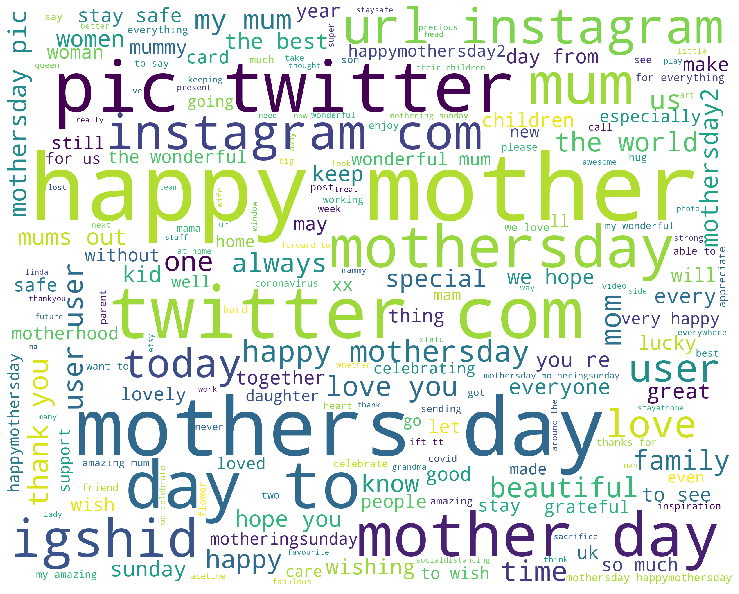

In [259]:
print("Positive words")
wordcloud_draw(train_pos,'white')

Negative words


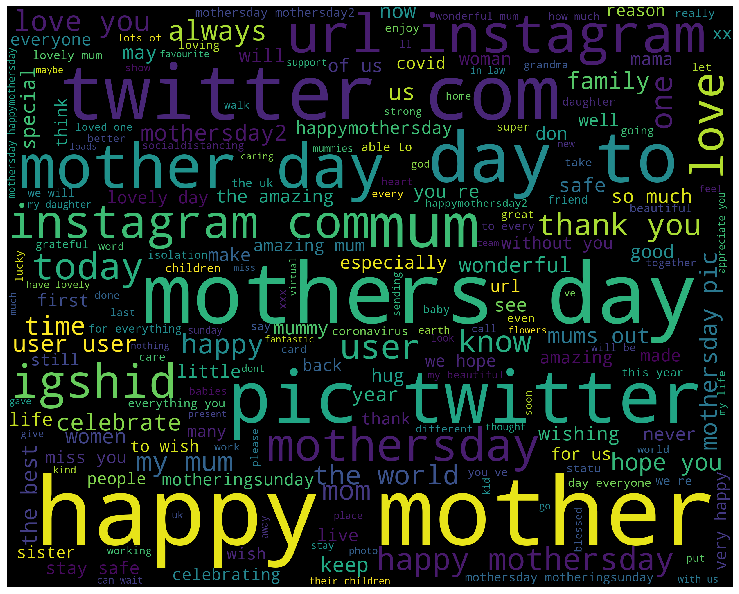

In [33]:
print("Negative words")
wordcloud_draw(train_neg,'black')

Nautral words


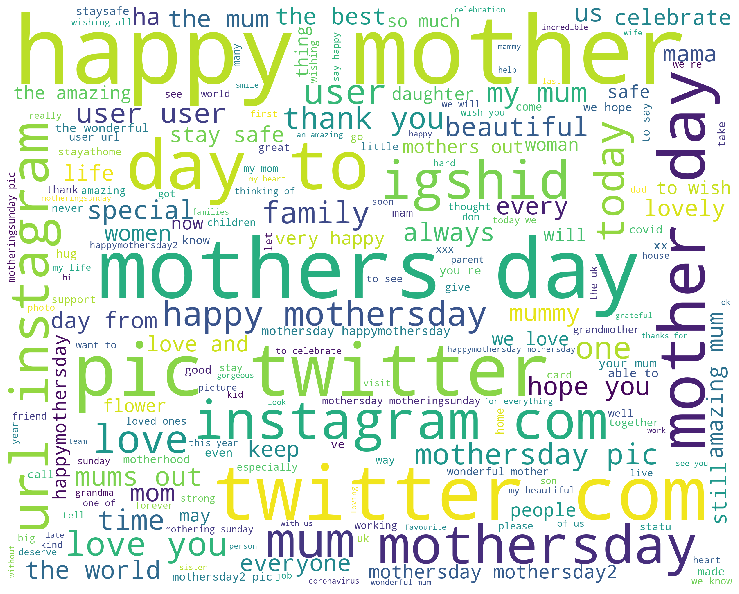

In [34]:
print("Nautral words")
wordcloud_draw(train_neu)

In [291]:
tweets = []
stopwords_set = set(stopwords.words("english"))
stopwords_set.update(('com','va4nfjfq5b','and','I','A','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these'))

for index, row in train.iterrows():
#     print(row.original_text)
    words_filtered = [e.lower() for e in row.original_text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and 'https' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and not word.endswith('.com')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment_class))
print(tweets)


[(['happy', 'mothersday', 'amazing', 'mothers', 'know', 'hard', 'able', 'see', 'mothers', 'today', 'protect', 'vulnerable', 'members', 'society', 'beatcoronavirus', 'pic', 'twitter'], 0), (['happy', 'mothers', 'day', 'mum', 'sorry', 'bring', 'mothers', 'day', 'flowers', 'cwtch', 'honestly', 'point', 'walk', 'hot', 'coals', 'able', 'bells', 'soon', 'love', 'lots', 'xxx', 'need', 'photos', 'photos', 'app', 'goo', 'm3vxblrsczd4te', 'by7'], 0), (['happy', 'mothers', 'day', 'mothers', 'days', 'work', 'today', 'quiet', 'time', 'reflect', 'dog', 'walk', 'finish', 'jigsaw', 'garden', 'learn', 'guitar', 'chords', 'drunk', 'strawberry', 'gin', 'tonic', 'watch', 'lee', 'evens', 'dvd', 'favourite', 'place', 'visit', 'isolate', 'pic', 'twitter', 'xvvf6f9'], -1), (['happy', 'mothers', 'day', 'beautiful', 'woman', 'royalty', 'soothes', 'mummy', 'jeremy', 'emerald', 'prayforroksie', 'ultimateloveng', 'pic', 'twitter', 'oeeti22pvv'], 0), (['remembering', 'amazing', 'ladies', 'made', 'late', 'grandmothe

In [292]:
test_pos = X_test[X_test['sentiment_class'] == 1]
test_pos = test_pos['original_text']
test_neg = X_test[X_test['sentiment_class'] == -1]
test_neg = test_neg['original_text']
test_neu = X_test[X_test['sentiment_class'] == 0]
test_neu = test_neu['original_text']

In [293]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [294]:
len(w_features)

13964

In [295]:
extract_features(tweets[0][0])

{'contains(happy)': True,
 'contains(mothersday)': True,
 'contains(amazing)': True,
 'contains(mothers)': True,
 'contains(know)': True,
 'contains(hard)': True,
 'contains(able)': True,
 'contains(see)': True,
 'contains(today)': True,
 'contains(protect)': True,
 'contains(vulnerable)': True,
 'contains(members)': True,
 'contains(society)': True,
 'contains(beatcoronavirus)': True,
 'contains(pic)': True,
 'contains(twitter)': True,
 'contains(day)': False,
 'contains(mum)': False,
 'contains(sorry)': False,
 'contains(bring)': False,
 'contains(flowers)': False,
 'contains(cwtch)': False,
 'contains(honestly)': False,
 'contains(point)': False,
 'contains(walk)': False,
 'contains(hot)': False,
 'contains(coals)': False,
 'contains(bells)': False,
 'contains(soon)': False,
 'contains(love)': False,
 'contains(lots)': False,
 'contains(xxx)': False,
 'contains(need)': False,
 'contains(photos)': False,
 'contains(app)': False,
 'contains(goo)': False,
 'contains(m3vxblrsczd4te)': F

In [296]:
w_features

dict_keys(['happy', 'mothersday', 'amazing', 'mothers', 'know', 'hard', 'able', 'see', 'today', 'protect', 'vulnerable', 'members', 'society', 'beatcoronavirus', 'pic', 'twitter', 'day', 'mum', 'sorry', 'bring', 'flowers', 'cwtch', 'honestly', 'point', 'walk', 'hot', 'coals', 'bells', 'soon', 'love', 'lots', 'xxx', 'need', 'photos', 'app', 'goo', 'm3vxblrsczd4te', 'by7', 'days', 'work', 'quiet', 'time', 'reflect', 'dog', 'finish', 'jigsaw', 'garden', 'learn', 'guitar', 'chords', 'drunk', 'strawberry', 'gin', 'tonic', 'watch', 'lee', 'evens', 'dvd', 'favourite', 'place', 'visit', 'isolate', 'xvvf6f9', 'beautiful', 'woman', 'royalty', 'soothes', 'mummy', 'jeremy', 'emerald', 'prayforroksie', 'ultimateloveng', 'oeeti22pvv', 'remembering', 'ladies', 'made', 'late', 'grandmother', 'iris', 'carol', 'great', 'ethel', 'missed', 'never', 'forgotten', 'mums', 'sent', 'xxxx', 'xzzzdeybje', 'mother', 'bratz', 'world', 'familiez', 'yasmin', 'portia', 'bratzworldfamiliez', 'bratz2', 'bratzkidz', 'br

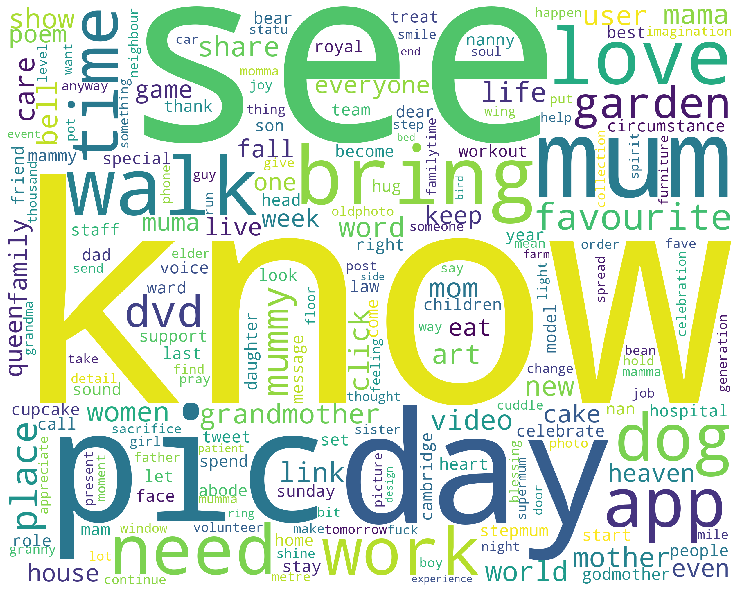

In [268]:
wordcloud_draw(w_features)

In [297]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
neg_cnt = 0
pos_cnt = 0
neu_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == -1): 
        neg_cnt = neg_cnt + 1

for obj in test_pos:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 1): 
        pos_cnt = pos_cnt + 1

for obj in test_neu:
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 0): 
        pos_cnt = neu_cnt + 1
        
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt)) 
print('[Natural]: %s/%s '  % (len(test_neu),neu_cnt)) 

## Naive Bayes

In [43]:
import random
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
X = train.original_text
y = train.sentiment_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='word',max_features=4000)
# analyzer='word', token_pattern=r'\w{1,}'

X_train_vect = vect.fit_transform(X_train)

In [45]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

nb.score(X_train_vect, y_train)


0.7915194346289752

In [46]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

# nb.score(X_test_vect, y_pred)
f1_score(y_test, y_pred,average='weighted') * 100

40.46280128085443

In [47]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 48.71%

F1 Score: 40.46

COnfusion Matrix:
 [[ 18 190  18]
 [ 41 433  38]
 [ 13 198  22]]


In [32]:
100*f1_score(y_test, y_pred, average='weighted')

39.20632999639474

In [380]:
test_final=test.original_text
final_test_vect = vect.transform(test_final)

y_pred_final = nb.predict(final_test_vect)

y_pred_final

array([-1,  0,  1, ...,  0,  0, -1], dtype=int64)

In [381]:
test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [382]:
test['sentiment_class']=y_pred_final

In [383]:
test.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood,-1
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii,0
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg,1
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters,0
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg,0


In [384]:
final=pd.DataFrame(test[['id','sentiment_class']])
final.head()

,id,sentiment_class
0,1.246628e+18,-1
1,1.245898e+18,0
2,1.244717e+18,1
3,1.245730e+18,0
4,1.244636e+18,0


In [385]:
final.to_csv('submissions.csv',index=False,sep=',')
# dt.to_csv('file_name.csv',sep='\t')

In [387]:
df_final=pd.read_csv('submissions.csv')
df_final.head()

,id,sentiment_class
0,1.246628e+18,-1
1,1.245898e+18,0
2,1.244717e+18,1
3,1.245730e+18,0
4,1.244636e+18,0


## Grid Search

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [34]:
X = train.original_text
y = train.sentiment_class
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [69]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring=None)
clf.fit(x_train, y_train)



print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000       387
           0     0.5179    1.0000    0.6824       838
           1     0.0000    0.0000    0.0000       393

    accuracy                         0.5179      1618
   macro avg     0.1726    0.3333    0.2275      1618
weighted avg     0.2682    0.5179    0.3534      1618



C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
100*f1_score(y_test, clf.predict(x_test),average='weighted')

35.343630089828196

In [220]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

X = train.original_text
y = train.sentiment_class


models = RandomForestClassifier()

sm = SMOTE()

# Init a dictionary for storing results of each run for each model

X_train_vect = vect.fit_transform(X_train)    
X_test_vect = vect.transform(X_test)

X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    

model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_vect)
        
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,average='weighted')
cm = confusion_matrix(y_test, y_pred)
    

In [226]:
slashes = '-' * 30
s = f"""{model}\n{slashes}
    Avg. Accuracy: {acc:.2f}%
    Avg. F1 Score: {f1:.2f}
    Avg. Confusion Matrix: 
    \n{cm}
    """
print(s)

RandomForestClassifier()
------------------------------
    Avg. Accuracy: 0.46%
    Avg. F1 Score: 0.40
    Avg. Confusion Matrix: 
    
[[ 15 111  19]
 [ 37 259  35]
 [ 18 129  24]]
    
